In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 980

nband = 120

nv = 200

dv = 0.005

tsfc =294

ng =4

nref =1

p_refs = (/ 50 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 4 /) 

data wgt
     &     /1 , 0.6 , 0.4 , 0.3/

option_wgt_flux =2

option_wgt_k =1

option_klin =0

data w_diffuse
     &     /1.6 , 1.6 , 1.6 , 1.6/

klin =0

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

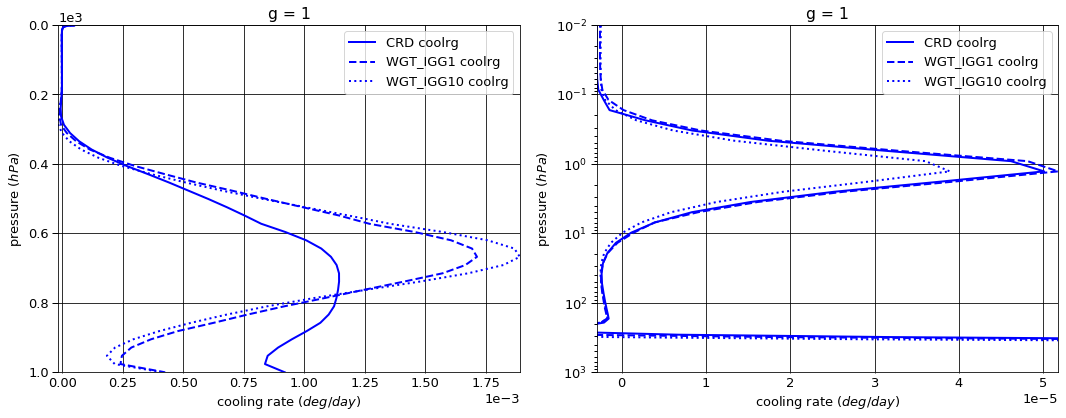

# Figure: cooling rate g-group 2

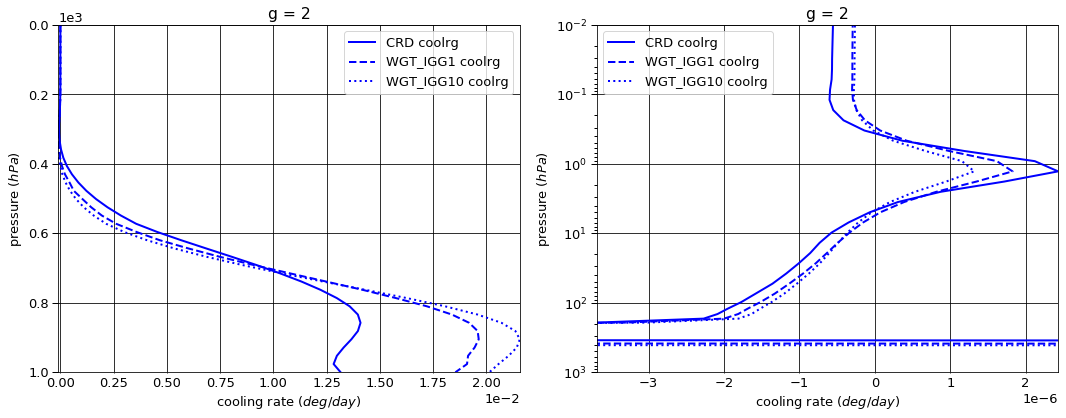

# Figure: cooling rate g-group 3

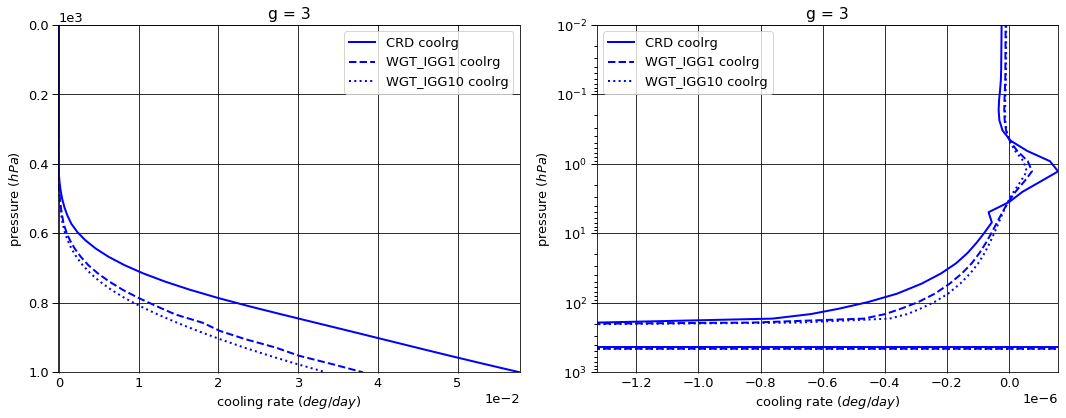

# Figure: cooling rate g-group 4

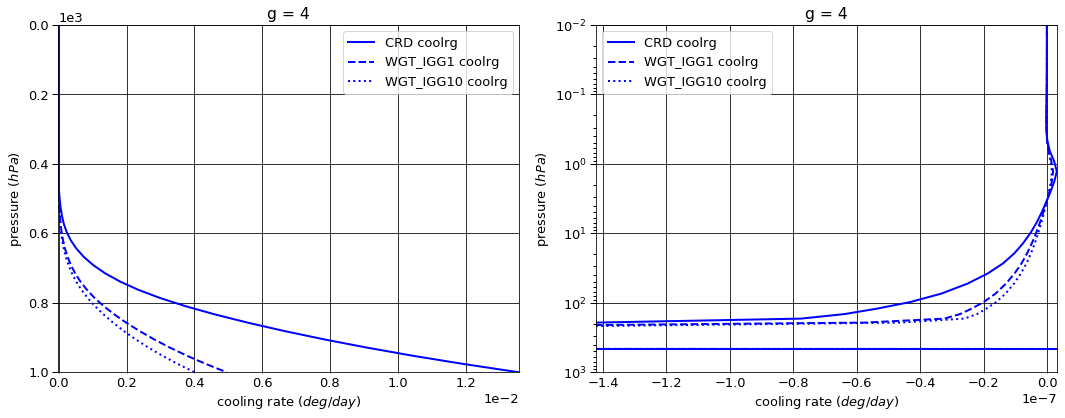

# Figure: cooling rate g-group total

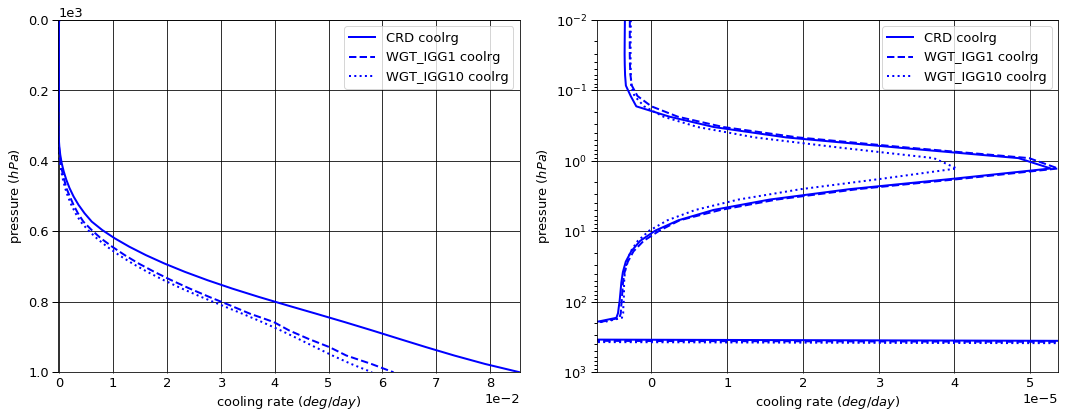

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.079427  0.000000  -0.079427
  1013.0   76     -0.114732  0.101190  -0.013541
2 0.0      1      -1.023786  0.000000  -1.023786
  1013.0   76     -1.207772  0.791988  -0.415784
3 0.0      1      -9.680516  0.000000  -9.680516
  1013.0   76     -9.881302  1.481285  -8.400017
4 0.0      1     -20.120391  0.000000 -20.120391
  1013.0   76    -20.150432  0.269784 -19.880648


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.070462  0.000000  -0.070462
  1013.0   76     -0.114732  0.112962  -0.001770
2 0.0      1      -1.025343  0.000000  -1.025343
  1013.0   76     -1.207772  0.921206  -0.286565
3 0.0      1      -9.778683  0.000000  -9.778683
  1013.0   76     -9.881302  0.832436  -9.048866
4 0.0      1     -20.139825  0.000000 -20.139825
  1013.0   76    -20.150432  0.096866 -20.053566


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.070648  0.000000  -0.070648
  1013.0   76     -0.114732  0.113120  -0.001611
2 0.0      1      -1.032224  0.000000  -1.032224
  1013.0   76     -1.207772  0.940187  -0.267584
3 0.0      1      -9.796002  0.000000  -9.796002
  1013.0   76     -9.881302  0.708501  -9.172801
4 0.0      1     -20.141887  0.000000 -20.141887
  1013.0   76    -20.150432  0.078164 -20.072268


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      8.964891e-03  0.000000  0.008965
  1013.0   76     0.000000e+00  0.011772  0.011772
2 0.0      1     -1.557900e-03  0.000000 -0.001558
  1013.0   76     0.000000e+00  0.129219  0.129219
3 0.0      1     -9.816710e-02  0.000000 -0.098167
  1013.0   76     0.000000e+00 -0.648849 -0.648849
4 0.0      1     -1.943400e-02  0.000000 -0.019434
  1013.0   76     3.552714e-15 -0.172918 -0.172918


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      8.778882e-03  0.000000  0.008779
  1013.0   76     0.000000e+00  0.011930  0.011930
2 0.0      1     -8.438100e-03  0.000000 -0.008438
  1013.0   76     0.000000e+00  0.148199  0.148199
3 0.0      1     -1.154854e-01  0.000000 -0.115485
  1013.0   76     0.000000e+00 -0.772784 -0.772784
4 0.0      1     -2.149600e-02  0.000000 -0.021496
  1013.0   76     3.552714e-15 -0.191620 -0.191620

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.792988e-06
  1001.112500 75     9.197496e-04
2 0.000312    1     -5.232162e-07
  1001.112500 75     1.316198e-02
3 0.000312    1     -2.120640e-08
  1001.112500 75     5.780819e-02
4 0.000312    1     -4.803261e-11
  1001.112500 75     1.358351e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -2.459411e-06
  1001.112500 75     4.252552e-04
2 0.000312    1     -2.805555e-07
  1001.112500 75     1.855008e-02
3 0.000312    1     -9.870701e-09
  1001.112500 75     3.811893e-02
4 0.000312    1     -4.803261e-11
  1001.112500 75     4.956177e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -2.311859e-06
  1001.112500 75     4.129105e-04
2 0.000312    1     -2.502799e-07
  1001.112500 75     2.014520e-02
3 0.000312    1     -7.997429e-09
  1001.112500 75     3.349298e-02
4 0.000312    1      0.000000e+00
  1001.112500 75     4.010835e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.335771e-07
  1001.112500 75    -4.944944e-04
2 0.000312    1      2.426607e-07
  1001.112500 75     5.388098e-03
3 0.000312    1      1.133570e-08
  1001.112500 75    -1.968925e-02
4 0.000312    1      0.000000e+00
  1001.112500 75    -8.627333e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.811289e-07
  1001.112500 75    -5.068391e-04
2 0.000312    1      2.729363e-07
  1001.112500 75     6.983213e-03
3 0.000312    1      1.320897e-08
  1001.112500 75    -2.431520e-02
4 0.000312    1      4.803261e-11
  1001.112500 75    -9.572675e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.904120,0.000000,-30.90412
1013.0,76,-31.354237,2.644247,-28.70999



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.014314,0.000000,-31.014314
1013.0,76,-31.354237,1.963471,-29.390767



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.040760,0.000000,-31.040760
1013.0,76,-31.354237,1.839973,-29.514265



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.101941e-01,0.000000,-0.110194
1013.0,76,3.552714e-15,-0.680776,-0.680776



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.366406e-01,0.000000,-0.136641
1013.0,76,3.552714e-15,-0.804274,-0.804274


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000003
1001.112500,75,0.085473



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000003
1001.112500,75,0.062050



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000003
1001.112500,75,0.058062



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,5.875735e-07
1001.112500,75,-2.342298e-02



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,7.673222e-07
1001.112500,75,-2.741150e-02


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.003750,0.003620
2,0.039167,0.038239
3,0.320417,0.312903
4,0.636667,0.645238


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.458881e-23
2,4.092653e-25
3,6.811963e-27
4,1.133809e-28


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.458881e-23,NaN,0.003750,0.003620,0.003750,0.003620,50.0
2,4.092653e-25,0.016644,0.039167,0.038239,0.042917,0.041859,50.0
3,6.811963e-27,0.016644,0.320417,0.312903,0.363333,0.354762,50.0
4,1.133809e-28,0.016644,0.636667,0.645238,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.031910e-23  7.700948e-24   3.937061  2.582009e-09
      2 0.000312     2.986082e-25  2.265198e-26  13.182435  1.602952e-11
      3 0.000312     1.278407e-27  1.553320e-28   8.230157  5.148518e-14
      4 0.000312     2.352528e-30  4.358636e-31   5.397395  8.608625e-17
2     1 0.000750     3.061873e-23  7.734987e-24   3.958472  1.050277e-09
      2 0.000750     3.006284e-25  2.274933e-26  13.214827  6.499390e-12
      3 0.000750     1.289991e-27  1.561906e-28   8.259083  2.091416e-14
      4 0.000750     2.385756e-30  4.443259e-31   5.369382  3.521951e-17
3     1 0.001052     3.126307e-23  7.806688e-24   4.004652  1.503889e-09
      2 0.001052     3.049581e-25  2.294499e-26  13.290835  9.243381e-12
      3 0.001052     1.314749e-27  1.578226e-28   8.330548  2.985321e-14
      4 0.001052     2.450440e-30  4.553141e-31   5.381866  5.069482e-17
4     1 0.001476     3.195818e-23  7.882478e-24   4.054332  2.156703e-09
      2 0.001476     3.096135e-25  2.315627e-26  13.370608  1.316167e-11
      3 0.001476     1.341544e-27  1.595917e-28   8.406099  4.267577e-14
      4 0.001476     2.522192e-30  4.684541e-31   5.384077  7.319276e-17
5     1 0.002070     3.266756e-23  7.958245e-24   4.104870  3.092109e-09
      2 0.002070     3.143492e-25  2.337346e-26  13.448978  1.873756e-11
      3 0.002070     1.369003e-27  1.614278e-28   8.480590  6.100040e-14
      4 0.002070     2.598298e-30  4.840050e-31   5.368329  1.058507e-16
6     1 0.002904     3.339082e-23  8.033954e-24   4.156212  4.433448e-09
      2 0.002904     3.191630e-25  2.359808e-26  13.524954  2.667930e-11
      3 0.002904     1.397143e-27  1.633553e-28   8.552783  8.721560e-14
      4 0.002904     2.679744e-30  5.029393e-31   5.328167  1.534847e-16
7     1 0.004074     3.412823e-23  8.109669e-24   4.208338  6.356468e-09
      2 0.004074     3.240575e-25  2.383260e-26  13.597235  3.798946e-11
      3 0.004074     1.426015e-27  1.654118e-28   8.620999  1.247246e-13
      4 0.004074     2.768005e-30  5.266572e-31   5.255800  2.233282e-16
8     1 0.005714     3.488010e-23  8.185490e-24   4.261211  9.112519e-09
      2 0.005714     3.290358e-25  2.408051e-26  13.663986  5.409333e-11
      3 0.005714     1.455689e-27  1.676510e-28   8.682855  1.784006e-13
      4 0.005714     2.865157e-30  5.571584e-31   5.142446  3.264504e-16
9     1 0.008015     3.564690e-23  8.261586e-24   4.314777  1.306327e-08
      2 0.008015     3.341029e-25  2.434685e-26  13.722633  7.703068e-11
      3 0.008015     1.486263e-27  1.701499e-28   8.735021  2.552763e-13
      4 0.008015     2.974158e-30  5.973012e-31   4.979327  4.801978e-16
10    1 0.011243     3.642889e-23  8.338174e-24   4.368928  1.872574e-08
      2 0.011243     3.392628e-25  2.463866e-26  13.769531  1.097019e-10
      3 0.011243     1.517856e-27  1.730177e-28   8.772836  3.654551e-13
      4 0.011243     3.099169e-30  6.511636e-31   4.759433  7.122299e-16
11    1 0.015771     3.722636e-23  8.415579e-24   4.423506  2.684194e-08
      2 0.015771     3.445214e-25  2.496601e-26  13.799614  1.562502e-10
      3 0.015771     1.550635e-27  1.764103e-28   8.789935  5.235521e-13
      4 0.015771     3.246112e-30  7.245685e-31   4.480063  1.067893e-15
12    1 0.022122     3.804017e-23  8.494321e-24   4.478306  3.847452e-08
      2 0.022122     3.498896e-25  2.534339e-26  13.805954  2.225839e-10
      3 0.022122     1.584852e-27  1.805510e-28   8.777867  7.507470e-13
      4 0.022122     3.423473e-30  8.258337e-31   4.145475  1.623453e-15
13    1 0.031031     3.887146e-23  8.575148e-24   4.533037  5.514809e-08
      2 0.031031     3.553831e-25  2.579136e-26  13.779154  3.171519e-10
      3 0.031031     1.620861e-27  1.857573e-28   8.725691  1.077949e-12
      4 0.031031     3.643359e-30  9.668260e-31   3.768370  2.510847e-15
14    1 0.043528     3.977629e-23  8.663780e-24   4.591101  7.915729e-08
      2 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
